# Operational Snow Water Equivalent (SWE) Products 
In this lab we will explore two operational SWE products to estimate basin wide SWE. These are standard products, produced in near real time (NRT), that are publically avalible. A word of caution: as you might remember from the lectures, estimating SWE in the mountains is hard. Operational SWE products perform better in large, flat areas with consisten depth and densisty of snowpack across many square kilometeres. Fortunatly, ongoing development of these products means they are continuously improving. While these products might not produce completely accurate basin scale SWE, they can often be used as an index along with data from previous years. 

## Two types of SWE products: Measurements and Models
There are two main catagories of operational SWE products: remotely sensed measurements of SWE and process based model estimates of SWE. We will explore an example of both. For measurement of SWE, we will look at data from the unified Advanced Microwave Scanning Radiometer (AMSR) SWE products which provide daily estimates of global SWE. Note that the product may not be available in some mountainous regions. For process based Model estimates of SWE we will explore the newest near real-time (NRT) ECWMF Re-analysis (ERA-5) SWE estimates. 

Goals of the lab:
- Gain familiarity with SWE plots
- Understand the two main sources of SWE estimates: remotely sensed measurements and process based models
- Gain familiarty with interpolation and smoothing of data
- Data science techniques to visualize the SWE in the context of historical records

# PART 1: AMSR-Unified SWE estimates

The first product we are going to look at is the AMSR Unifed SWE product. These data are collected from satellites that measure the emission of microwave radiation from Earth. Snow scatters and absorbs the microwave radiation.  Based on the measured reduction in passive microwave signal, we can estimate the snow water equivalent. This method works best in areas that have shallow snowpack, are devoid of forests, and are flat for at least 25 kilometers.

This AMSR-E Unified SWE product is produced using data collected by the Advanced Microwave Scanning Radiometer (AMSR-E) on board the Aqua satellite from June 2002 to October 2011, and from the Advanced Microwave Scanning Radiometer 2 (AMSR2) on board the JAXA GCOM-W1 satellite from July 2012 to the present. The purpose of the AMSR Unified Data Set is to provide the science community with intercalibrated climate products from both the AMSR-E and the AMSR2 instruments. 

The data sets are archived here:

AMSR-E SWE: 2002-2011
https://nsidc.org/data/AE_DySno/versions/2


AMSR2 SWE: 2012-now 
https://nsidc.org/data/AU_DySno/versions/1


These data are avalible as daily, 5-day maximum, and monthly maximum datasets. We will look at the daily data in this lab exercise. 

## Set up the Lab workspace
To explore these datasets we need to import the required packages for geospatial analysis in python.

In [4]:
import geopandas as gpd # extension of pandas that handles geographic information
import rasterio as rio # importing, exporting, and manipulating raster datasets 
from rasterio.plot import show # plot tools for raster datasets
import numpy as np # basic math
import pandas as pd # manipulate tables
import matplotlib.image as mpimg # making data viz pretty
import matplotlib.pyplot as plt
import os # comes with basic standard python lets you do anything you can do in a terminal but in python
import glob # comes with basic standard python uses regular expressions to work with data
import contextily as ctx
%matplotlib inline 
# magic commands

## Choose an Area of Interest
We have three different AOIs. Choose one of the following to complete your lab: Langtang catchment in Nepal, Panjsher basin in Afganistan, or wangchu watershed in Bhutan. 

In [18]:
# list all the files in our directory to see what is avalible and what we are working with in the lab

# os.listdir('.') two dots shows what server we are in right not
myDir = os.getcwd() # current working directory
myFile = os.listdir(myDir) # powerful way to use objects 
print(myFile[10])
# os.mkdir('foo') # foo directory shows up

.ipynb_checkpoints


In [23]:
#what about just shapefiles or just tiff files? Can we get a list of all the shapefiles or
#just the tiff files we have to work with?

myTiffs = glob.glob('*.tif')
print(myTiffs)

['langtang_catchment_nepal_AMSR_SWE.tif', 'langtang_catchment_nepal_basinMask.tif', 'langtang_catchment_nepal_ERA5_SWE.tif', 'panjsher_basin_afghanistan_basinMask.tif', 'wangchu_watershed_bhutan_AMSR_SWE.tif', 'wangchu_watershed_bhutan_ERA5_SWE.tif', 'panjsher_basin_afghanistan_AMSR_SWE.tif', 'wangchu_watershed_bhutan_basinMask.tif', 'panjsher_basin_afghanistan_ERA5_SWE.tif']


In [24]:
myTiffs[0] # index in myTiffs variable

'langtang_catchment_nepal_AMSR_SWE.tif'

In [27]:
#lets look at the Area of Interest (AOI) on a map. Pick one of the following:

#choose on of the following areas for your labratory. 
#Feel free to explore each of them!
#panjsher_basin_afghanistan
#wangchu_watershed_bhutan
#langtang_catchment_nepal
############## INSERT AOI WATERSHED NAME HERE ###################
watershedName = 'panjsher_basin_afghanistan'
#################################################################
aoiFile = watershedName + '_wgs84.shp'
basinMaskFile = watershedName + '_basinMask.tif'
aoi_AMSR_SWE = watershedName + '_AMSR_SWE.tif'


## Plot the Area of Interest on a basemap

In [29]:
#load the shapefile with geopandas and display on a basemap with contextily
#The 'EPSG' codes are standerdized information that discribe which projection the datasets 
#are in. We want to add basemap in same projection as the SWE data and AOI data

#load the shapefile into python

AOI = gpd.read_file(aoiFile)

#what is the projection of this shapefile?

AOI.crs # prints all the information about the crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

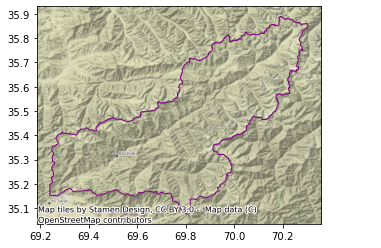

In [35]:
#plot the shapefile over a basemap (in the same projection)

ax = AOI.plot(edgecolor = 'purple', facecolor = 'None')
ctx.add_basemap(ax, crs = 'EPSG:4326') # can input crs as 4326 without the quotes and without EPSG

## Visualize the AMSR-E SWE data

First, it is importnat to see how the data are packaged. The datasets are packaged for the entire northern hemisphere as a single image each day in the daily dataset. This is not very useful for looking a small basin over many days or months! Lets see what the full dataset look like for one day.

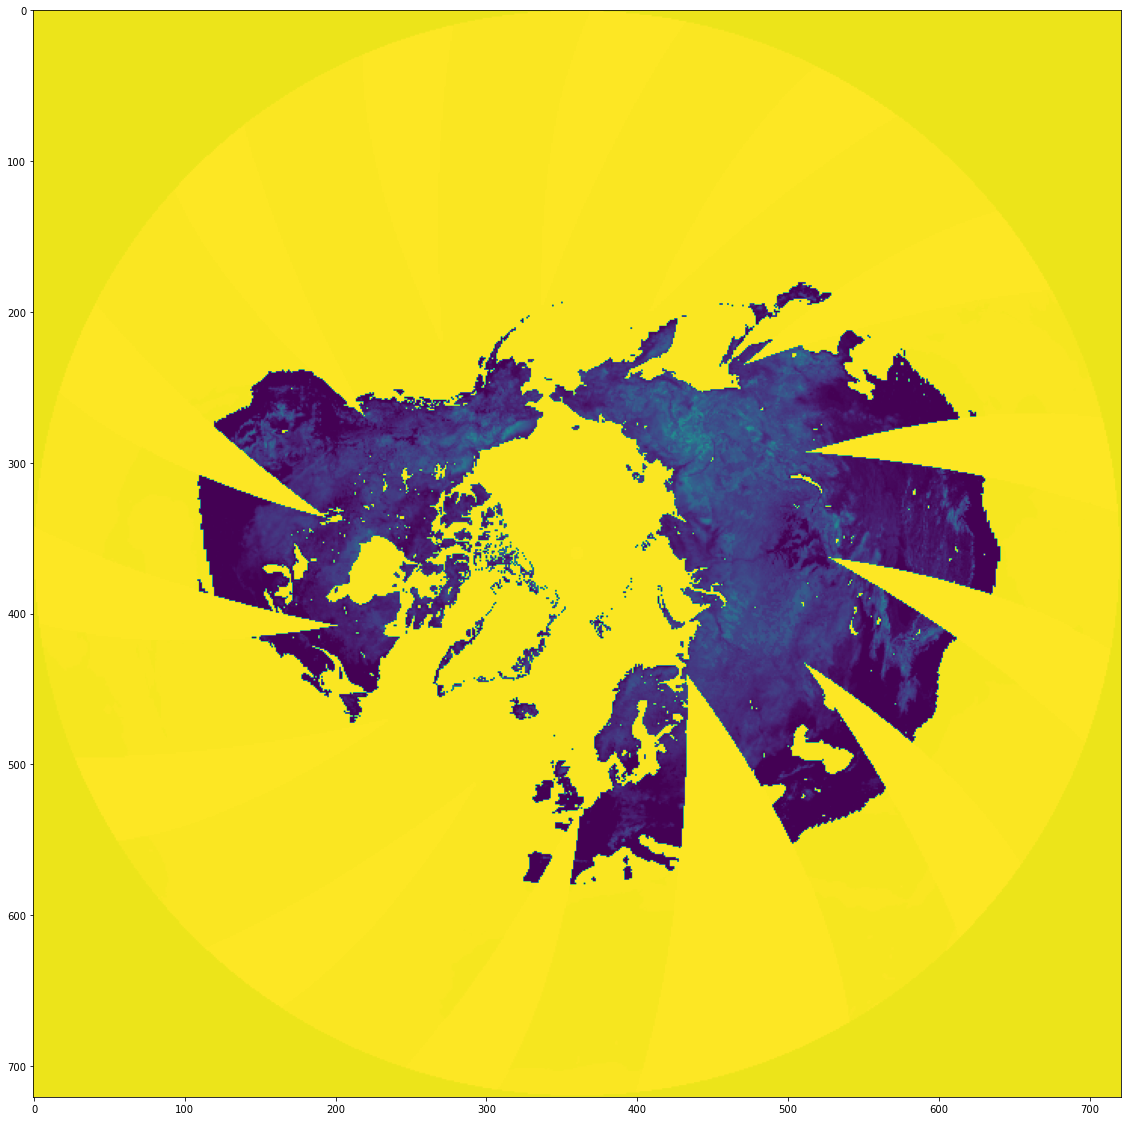

In [39]:
#load one day of AMSR data 'fullAMSR_SWE_20100218.png' and print an image to the screen
# use matplotlib (mpimg)

amsrSWEimg = mpimg.imread('fullAMSR_SWE_20100218.png')
plt.figure(figsize = (20, 20))
plt.imshow(amsrSWEimg)       

interesting? Do you recognize any land features on earth? Where are we looking at earth from? This is a unique projection. More information is here:
https://nsidc.org/ease/ease-grid-projection-gt

HD: We see data gaps here because of orbits. See NASA Worldview as an example of this. Because of the orbits satelites miss capturing the data

## Explore AMSR SWE for our Area of Interest

We have reprojected, cropped, and assembled data cubes of the full AMSR Unifed SWE records for this lab for each area of interest. 

A data cube is a stack of data, for Earth science datasets, one common type of datacube is a "time/space" cube. This is when we have data for a specific area, for many days, all assembled into a single file for analysis. For this lab we will be working with time/space datacubs of AMSR SWE data. 

To start, we will load the datacube, and visualize a few days to get a sense of the SWE data that we have to work with. 
## Load SWE datacube and check size

In [43]:
#load the basin mask and see how big it is

bmask = rio.open(basinMaskFile) # tiff files with raster data
basinMask = bmask.read()
basinMask.shape

(1, 5, 9)

Size is (1, 5, 9). This tells us there is 1 band of data with 5 rows and 9 columns.

In [49]:
# is it the correct size? if not, fix it. 

basinMask = np.squeeze(basinMask)
baskinMask

array([[[0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0]]], dtype=uint8)

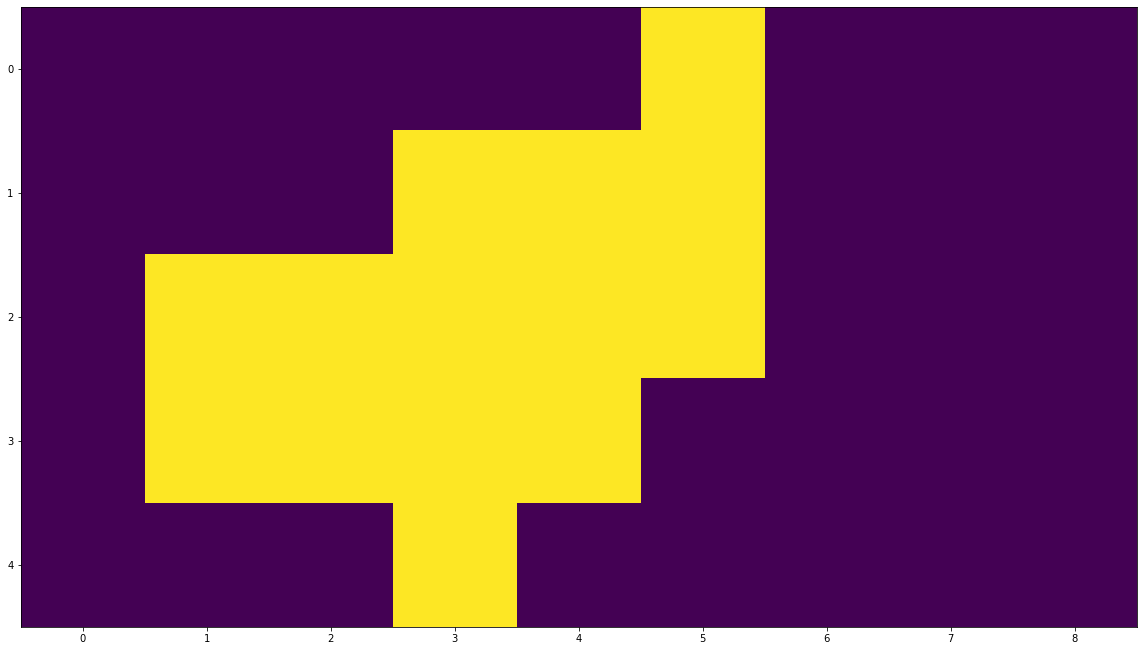

In [ ]:
#plot the basin mask
# first time plotting we get an error that says invalid shape size. We need to remove the 1
# plt.figure(figsize = (20, 20))
# plt.imshow(basinMask)

plt.figure(figsize = (20, 20))
plt.imshow(basinMask)


HD: Mask is a logical...

In [55]:
#load the AMSR SWE dataset

aoi_AMSR_SWE = watershedName + '_AMSR_SWE.tif'
SWE = rio.open(aoi_AMSR_SWE)
SWEarray = SWE.read() # got a warning that there are extra samples in data set

#see how big the dataset is - what does each dimension represent? 
sz = SWEarray.shape
print(sz) # we have 3364 bands of data that are all the same size
# we have daily data over 10 years so that's where the 3364 comes from
# this is called a spatial cube 

(3364, 5, 9)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Now we have loaded the SWE datacube for our study area. the ***'.shape'*** command lets us see the size of our datacube. From this, can you figure out how many days of data are in the datacube? what about how many measurements per day?

## Plot SWE at one location for entire data record
Next, we will load up the dates for these data, which are stored seperatly and plot one of the pixels in the datacube for the whole record of data. We need to find a location to plot the SWE at. Looking at the basemap above, and using your knowledge of the basin, we can take latitude and longitude coordinates and with them figure out which pixel in the image represents the SWE at that location. 
### Pick a location to map SWE and convert back and forth between lat/lon and pixel coordinates

In [59]:
#hint(70,35.75) is within our AOI

#longitude of point of interest
lon = 70

#latitude of point of interest
lat = 35.75

#convert longitude and latitude to pixel 'row/column' coordinates
pxlIdx = SWE.index(lon, lat) # this is saying that lon, lat is located at 1 (second row), 4 (fifth column)
print(pxlIdx)

(1, 4)


This transformation can also go in the other direction, we can take a pixel coordinate and convert it to latitude and longitude:

In [63]:
#convert backwards from row/colum to latitude/longitude

#pixel row
row = pxlIdx[0]

#pixel column
col = pxlIdx[1]

#convert pixel row and column to latitude and longitude
SWE.xy(row, col)

(70.0, 35.75)

In [ ]:
#load the dates for the dataset - look at the csv and load it into a dataframe with a column name
dateFile=watershedName+'AMSR_sweDates.csv'

#here we extract the timeseries of SWE data from the pixel that is at the 
#latitude and longitude of our point of interest


#assign the data from our lat/lon point to a 'SWE_mm' column in the dataframe with measurement dates

#set the dates as the index for the dataframe

#values above 240 are various flags for no data, we will set to NaN




Now that we have the data organized into a DataFrame, lets plot one of the pixels in the datacube for the whole record of data.

In [ ]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(pointSWEdf.index.values,
        pointSWEdf['SWE_mm'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Snow Water Equivalent (mm)",
       title="Daily Snow Water Equivalent \n" + watershedName)

# Rotate tick marks on x-axis
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

## Explore one water year of data
Often we would like to see how snow accumulates and melts over a year. Lets look closey at one water year of data, the 2004-2005 water year which begins October 1, 2004 and ends September 30, 2005.
### Pick a water year to explore

In [ ]:
#pick a water year and pull all the data for our point of interest into a new variable for just that water year


### Plot SWE for the water year

In [ ]:
# Create figure and plot space

# Add data

# Set title and labels for axes

# Rotate tick marks on x-axis


anything look weird? Why does the SWE disapear on lots of days within the data series?


This is because the satellite does not take a measurement everyday. Sometimes the pixel is not imaged by the satellite, so there are fill values in the datasets on those days. What can we do about this? One solution is to interpolate the value based on measurements on the preceeding days and following days that are valid measurements. This task is very common with satellite snow observations. Many times there are numerious days where we just do not have a good measurement. This can be becuase of cloud cover, no image was taken on that day, or the image is of poor quality for a variety of reasons. (off nadir satellite view angle, noise, etc....)

## Fill and smooth AMSR SWE datacube
Now we will smooth the data to remove inconsistencies. This is an example of a simple way to smooth the data. In the lectures, Karl will show you some of our more advanced routines and we will see the quality of the research grade SWE products that include more difficult time/space smoothing. For now, we will explore how smoothing works with some simpler methods. 

In [ ]:
#calculate the cubic spline estimate of the AMSR data 

# 7 day  moving average of the interpolated data in the cubic spline estimate

#plot the smoothed output.
# Create figure and plot space

# Add data points and line color

# Set title and labels for axes

# Rotate tick marks on x-axis


## What is the maximum SWE value at the point durring the water year?

In [ ]:
#find the maximum SWE value from the water year


## Compare original SWE with interpolated and smoothed SWE

In [ ]:
#define plot space

#plot original SWE data as a solid green line


#plot interpolated and smoothed SWE data as a dashed black line


# Set title and labels for axes


#set axis limits


# Rotate tick marks on x-axis


#let python choose where to put the legend




## Calculate volume of SWE in the basin each day

In [ ]:
#write a function to calculate the volume of SWE wihtin the basin each day


#call the function compute_volume and use the dataCube and basinMask to figure out basin SWE.
    
    #find all the pixels within the basin
    
    #initalize output as the right size and datatype
  
    #calculate basin SWE volume each day and store the answer
   
        
        #remeber that values above 240 are fill in the original dataset, so we dont want to add - assume missing data
        daySWE[daySWE>240]=0
        
        #volume of water in each pixel
        #SWE*area=volumne of water - we want volume in cubic kilometers
        swe2km3=(31**2)/1000000

        #volume of water in the basin
        #all data for this lab has been reporjected to 31km pixels equivalent to the ERA-5 grid.
        #AMSR-U SWE is in 25km native resolution 
        #calculate basin volume for the day and save in output
        
        
        #finish the fucntion and return the output

        
#use the funciton to calculate basin volume and see the size of our answer


Lets make a new dataframe with the new basin-wide SWE volume data included.

In [ ]:
#load AMSR SWE dates and set date/time as index
dateFile=watershedName+'AMSR_sweDates.csv'
basinSWEdf=pd.read_csv(dateFile,header=None,names=['sweDates'])
basinSWEdf['sweDates']=pd.to_datetime(basinSWEdf['sweDates'],format='%Y%m%d')
basinSWEdf=basinSWEdf.set_index('sweDates')

#Add basin wide SWE to the dataframe

#look at the head of the dataset to gut check it

In [ ]:
# Create figure and plot space

# Add basinwide SWE data to plot as a purple line


# Set title and labels for axes


# Rotate tick marks on x-axis


Lets look at basin-wide water volume for the 2004-2005 water year again.

In [ ]:
# create a data frame for the 2004-2005 water year

# Create figure and plot space

# plot the water year data with a purple line

# Set title and labels for axes

# Rotate tick marks on x-axis


Here, we can really see those interpolated values in our data which have replaced the fill values. Lets smooth these also and see what it looks like.

In [ ]:

#calculate the cubic spline estimate of the basin wide AMSR data 

# 7 day  moving average of the interpolated data

#plot the smoothed output
# Create figure and plot space

# plot the smooth data (after the cubic spline or after the rolling average)


# Set title and labels for axes

# Rotate tick marks on x-axis



## Compare original basin wide SWE with interpolated and smoothed basin wide SWE

In [ ]:
#define plot space

#plot original basin wide SWE data as green

#plot interpolated and smoothed SWE data as a dashed black line

# Set title and labels for axes

#set axis limits

# Rotate tick marks on x-axis


It is important to remeber:
SWE is not streamflow. Many physical processes are occuring in the environment for example, sublimation, evaporation, transpiration, recharging groundwater, and human's consumptive use.
These are SWE estimates. Operational products are not highly accurate over mountainous terrain.
However, the tools and techniques that we can use to work with the data and get information from it (i.e SWE to water volume) are still useful in understanding the relative amounts of SWE.


# PART 2: ERA-5 SWE
Lets look at the ERA-5 data now. 

ERA5 is a process based physical model of the earth. Equations that model the evolution of the earth system are combined with measurements (when avalible) to provide the best possible estimate of the state of the earth at each time step. 
https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5

ERA5 provides hourly estimates of many meteorology and hydrology parameters going back to 1979. 
The volume of data form ERA5 is huge, so we have ordered the data nessesary for the lab from the online data repository:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview  
The webpage above shows the full list of variables that are avalible from ERA5 and another tab for downloading the data locally.

We want to look at the snow water equivalent, which is stored as parameter 141:  
https://apps.ecmwf.int/codes/grib/param-db?id=141

Now we will perfrom some of the same analysis as above on ERA5 data.

## load ERA-5

In [ ]:
# Load ERA5 SWE as a data frame


data frame of era5 + dates for one pixel (same pixel as the AMSR part of the lab)

In [ ]:
# Load dates 

#load ERA 5 SWE data for same Lat/Lon as part 1

#set index for the data frame as the date each day


#display the first 5 values in the data frame


In [ ]:
# Create figure and plot space

# plot all the ERA 5 data


# Set title and labels for axes

# Rotate tick marks on x-axis


Look Different? ERA5 gives a much longer historical record of the SWE for the location. This is a nice feture of the models and a dangerous one. They can calculate values for times when they do not have much data. 

## Trim the dataset to full water years of data only
We can see from the above graph that the dataset starts midway through a water year and ends midway through a water year. To run statistical analysis on full water years of data, lets trim the dataset to full water years of data.

In [ ]:
#trim the dataset to only cover full water years


In [ ]:
#replot the data with only complete water years of data



Lets look at the 2004-2005 water year like we did with AMSR. Again, the water year starts October 1, 2004 and ends September 30, 2005.

In [ ]:
#pick a water year and exract the lat/lon point data from that location for the water year


# Create figure and plot space

#plot the data

# Set title and labels for axes

# Rotate tick marks on x-axis


You can see there is no need to interpolate or smooth! An advantage of model outputs relative to satellite observations is that they are continous. The physical equations are used to generate estimates between measurements, this is a form of "data assimmilation" where the combination of models and measuremtns enable you to make the best estimate possible, considering all sources of information you have available, at any timestep.

With the long history of data available from the model we can contextualize any year within the historical context.

In [ ]:
#find out how many years of data are in the ERA5 dataset


In [ ]:
#Create figure and plot space

#plot all the background years as grey lines


# Add x-axis and y-axis 
# hint( x axis is not year this time becuase we have lots of years overlaied )


#highlight the 2004-2005 water year as a purple line


# Set title and labels for axes


This graph gives some context of the highlighted year we are interested in, in the context of other years. But the graph is still kind of messy. Lets look at another way we can visualize a year of interest in the context of the historical record. What is the driest year? The wettest year? To figure this out, and plot them along with some more historical context, we will use on of the more powerful datascience functions in python the "GroupBy" function you can use on pandas dataframes. We can use GroupBy to find the maximum SWE of each calendar year, which we can see from the above graph, for these pixels occurs at peak SWE each spring. [add some more info about group by and some links to good online references]  First, lets use GroupBy to see what the peak SWE was each year for this pixel. 

In [ ]:
#use groupby to split the dataframe into tables for each year, and then find the maximum value in the 'SWE_mm' column

#the data starts in october of 1979 so the peak in 1979 is not the peak for the water year
#drop the 1979 peak

#view results


Now that we have a list of the peak SWE each year, we can use this information to identify the water year that had the largest snowpack and the water year that had the smallest snowpack for our contextualization graph.

In [ ]:
#what was the driest year?


In [ ]:
#what was the wettest year? 


In [ ]:
#save these two years in a list and print to screen


In [ ]:
#how different are the wettest and the driest year? Plot both of them on the same graph



Now that we know the wettest and driest years, lets use that information to add historical context to our graph of the year of interest. In additon, we can look at the interquartile range of SWE through time. This is the bounds for any given day for which the SWE model is within the range 50% of the time. 

In [ ]:
#find the interquartile range (25th percintile and 75th percintile of SWE from ERA-5 for this pixel 
#for each day of year across the record. (day of water year = DOWY)


In [ ]:
#plot the wettest year, the driest year, the interquartile range, and the year of interest on a single graph


This is interesting, dicuss with fellow students how you would interpret this graph. Is the wettest year always the most swe on a given day for a pixel? Is the driest year always the driest? 
lets now calcuate basin wide storage

# PART 3: Challenge Quesiton (optional)
Above we made a graph of the ERA-5 data showing the minimum year, maximum year, interquartile range, and current year, from data that spanned a 41 year record. 
## What is the minimum SWE year and maximum SWE year in the AMSR SWE dataset? 
Below is some code to get you started, with the AMSR data set you need to answer the question interpolated, smoothed, and plotted for you. To answer the quesiton you will have to modify and add to the codebase below based on what we have used in the lab above. 

In [ ]:
#record of AMSR SWE data for the same point as the ERA 5 data
#calculate the cubic spline estimate of the AMSR data 
amsrSWE_interp_fullRecord=pointSWEdf['SWE_mm'].interpolate(method='cubicspline')

# 7 day  moving average of the interpolated data
amsrSWE_avg_fullRecord=amsrSWE_interp_fullRecord.rolling(7).mean()

#trim to full water years
amsrSWE_avg_fullRecord = amsrSWE_avg_fullRecord[~(amsrSWE_avg_fullRecord.index < '2002-10-01')]
amsrSWE_avg_fullRecord = amsrSWE_avg_fullRecord[~(amsrSWE_avg_fullRecord.index > '2011-08-30')]

#plot the smoothed output
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(amsrSWE_avg_fullRecord.index.values,
        amsrSWE_avg_fullRecord,
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Snow Water Equivalent (km3)",
       title="Daily Snow Water Equivalent \n" + watershedName)

# Rotate tick marks on x-axis
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()


## Use the code base from the ERA 5 section of the lab to calculate the wettest and driest year
hint: the comments in the empty code below match the comments in the ERA 5 section of the code above

In [ ]:
#use groupby to split the dataframe into tables for each year,
#then find the maximum value in the 'SWE_mm' column

#what was the driest year?

#what was the wettest year? for this we use .idxmax() instead of .idxmin()

